# Run Predictions

In [1]:
import json
import urllib.request
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

from src.ml.ctw import MyCTW
from src.dao import csv_dao
from src.entity.stop_region import StopRegionGroup, sr_row_to_stop_region
from src.exceptions import exceptions
from src.utils.others import remove_list_elements
from src.exceptions.exceptions import NoCategoryMatched

from src.experiments.ctw_eval import evaluation_ctw_k_fold_light_mem, evaluation_ctw_all_users_vs_one_light_mem, evaluation_ctw_light_mem
from src.experiments.markov_eval import evaluation_markov_k_fold_light_mem, evaluation_markov_all_users_vs_one_light_mem

from src.taxonomy.category_mapping import CategoryMapper

from src.exceptions.exceptions import NoCategoryMatched, NotValidTypes

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

working dir /home/tales/dev/master/mdc_analysis


## Loading Data

In [2]:
def get_users_tags_sequence():
    url = "http://127.0.0.1:5000/stop_regions_group"
    response = urllib.request.urlopen(url)
    return json.loads(response.read())

def load_users_tags_sequence():
    with open('outputs/users_tags_sequence.json') as json_file:
        return json.load(json_file)
    
users_tags_sequence = load_users_tags_sequence()

In [3]:
def clean_sequence(sequence):
    new_sequence = []
    
    for tags in sequence:
        if "parking" in tags:
            continue
        else:
            new_sequence.append(tags)

    return new_sequence

In [4]:
pd.Series(list(users_tags_sequence.keys())).sample(5)

4      6085
127    5943
30     6100
16     5941
67     5950
dtype: object

In [5]:
categ_mapper = CategoryMapper()

users_categ_sequence = {}
users_categ_sequence_not_list = {}

for user_id in list(users_tags_sequence.keys()):
    print("user_id:", user_id)
    
    users_tags_sequence[user_id] = clean_sequence(users_tags_sequence[user_id])
    
    if len( remove_list_elements(users_tags_sequence[user_id], elements=[[]]) ) < 8:
        continue 
    
    categ_sequence = []

    for tags in users_tags_sequence[user_id]:
        if tags == ["WORK"] or tags == ["HOME"]:
            categ_sequence.append(tags)

        else:
            try:
#                 print("tags:", tags)
                categ = categ_mapper.map_categ(tags, method="most_specific")
                categ_sequence.append([categ])

            except NotValidTypes:
                pass
            
            except NoCategoryMatched:
                categ_sequence.append(["NoCategoryMatched"]) 

    users_categ_sequence[user_id] = categ_sequence
    users_categ_sequence_not_list[user_id] = [categ[0] for categ in categ_sequence]
    

user_id: 6189
user_id: 5936
user_id: 6087
user_id: 5973
user_id: 6085
user_id: 6074
user_id: 6012
user_id: 5982
user_id: 5948
user_id: 5974
user_id: 6090
user_id: 6199
user_id: 6068
user_id: 6024
user_id: 5976
user_id: 6094
user_id: 5941
user_id: 5995
user_id: 5962
user_id: 6093
user_id: 6033
user_id: 6079
user_id: 6038
user_id: 6175
user_id: 6042
user_id: 5924
user_id: 6083
user_id: 6178
user_id: 5958
user_id: 6086
user_id: 6100
user_id: 5945
user_id: 5925
user_id: 5935
user_id: 6172
user_id: 5955
user_id: 6073
user_id: 5980
user_id: 6010
user_id: 5993
user_id: 6037
user_id: 5979
user_id: 5966
user_id: 5985
user_id: 5967
user_id: 5970
user_id: 6169
user_id: 6188
user_id: 6097
user_id: 6096
user_id: 6041
user_id: 6192
user_id: 6064
user_id: 6183
user_id: 5954
user_id: 5972
user_id: 6060
user_id: 6069
user_id: 5937
user_id: 6028
user_id: 5990
user_id: 6071
user_id: 5928
user_id: 5992
user_id: 6058
user_id: 6001
user_id: 5964
user_id: 5950
user_id: 5991
user_id: 6177
user_id: 5961
user_i

In [6]:
# users_tags_sequence = {}

# users = os.listdir("outputs/stop_regions/")
# users.reverse()

# for user_id in users:
#     print("Loading user {} data".format(user_id))
#     users_tags_sequence[user_id] = StopRegionGroup(csv_dao.stop_region_sequence(user_id), 
#                                                     agglutinate_stop_regions=True).sequence_stop_region_tags()["tag"].tolist()

## CTW

#### Train and Test with the same user

In [7]:
skipped_users = []

k=4

depths = [2]

predict_choice_methods = ["random_choice", "most_likely", "random_dummy"]

n=0
for user_id in list(users_categ_sequence.keys()):
    n += 1
    print("n:", n, "-", "user_id:", user_id)
    
    for depth in depths:
        
        for predict_choice_method in predict_choice_methods:
    
            tags_sequence = [categ[0] for categ in users_categ_sequence[user_id]]
            
            if len( remove_list_elements(tags_sequence, elements=[[]]) ) < 8:
                skipped_users.append(user_id)
                continue    

            try:
                evaluation_ctw_k_fold_light_mem(tags_sequence=tags_sequence, 
                                                user_id=user_id, 
                                                input_data_version="0.0.categ_v1", 
                                                predict_choice_method=predict_choice_method,
                                                dir_name="dossie_ctw/", 
                                                k=k, 
                                                depth=depth, 
                                                save_result=True)
                
                evaluation_ctw_light_mem(tags_sequence=tags_sequence, 
                                                user_id=user_id, 
                                                input_data_version="0.0.categ_v1", 
                                                predict_choice_method=predict_choice_method,
                                                dir_name="dossie_ctw/", 
                                                depth=depth, 
                                                save_result=True)

            except exceptions.TagsLengthNeedsToBeGreaterThanK:
                print("TagsLengthNeedsToBeGreaterThanK")



n: 1 - user_id: 6189
n: 2 - user_id: 5936
n: 3 - user_id: 6087
n: 4 - user_id: 5973
n: 5 - user_id: 6085
n: 6 - user_id: 6074
n: 7 - user_id: 6012
n: 8 - user_id: 5982
n: 9 - user_id: 5948
n: 10 - user_id: 5974
n: 11 - user_id: 6090
n: 12 - user_id: 6199
n: 13 - user_id: 6068
n: 14 - user_id: 6024
n: 15 - user_id: 5976
n: 16 - user_id: 6094
n: 17 - user_id: 5941
n: 18 - user_id: 5995
n: 19 - user_id: 5962
n: 20 - user_id: 6093
n: 21 - user_id: 6033
n: 22 - user_id: 6079
n: 23 - user_id: 6038
n: 24 - user_id: 6175
n: 25 - user_id: 6042
n: 26 - user_id: 5924
n: 27 - user_id: 6083
n: 28 - user_id: 6178
n: 29 - user_id: 5958
n: 30 - user_id: 6086
n: 31 - user_id: 5945
n: 32 - user_id: 5925
n: 33 - user_id: 5935
n: 34 - user_id: 6172
n: 35 - user_id: 5955
n: 36 - user_id: 6073
n: 37 - user_id: 5980
n: 38 - user_id: 6010
n: 39 - user_id: 5993
n: 40 - user_id: 6037
n: 41 - user_id: 5979
n: 42 - user_id: 5966
n: 43 - user_id: 5985
n: 44 - user_id: 5967
n: 45 - user_id: 5970
n: 46 - user_id: 61

#### Test with one user, train with all the rest of them

In [8]:
predict_choice_methods = ["random_choice", "most_likely", "random_dummy"]
depths = [2]

for depth in depths:
    print("depth:", depth)
    for predict_choice_method in predict_choice_methods:
        print("predict_choice_method:", predict_choice_method)
        
        evaluation_ctw_all_users_vs_one_light_mem(users_tags_sequence=users_categ_sequence_not_list, 
                                                  input_data_version="0.0.categ_v1",
                                                  predict_choice_method=predict_choice_method, 
                                                  dir_name="dossie_ctw/",
                                                  depth=depth,
                                                  save_result=True)

depth: 2
predict_choice_method: random_choice
n: 1 - test_user: 6189
n: 2 - test_user: 5936
n: 3 - test_user: 6087
n: 4 - test_user: 5973
n: 5 - test_user: 6085
n: 6 - test_user: 6074
n: 7 - test_user: 6012
n: 8 - test_user: 5982
n: 9 - test_user: 5948
n: 10 - test_user: 5974
n: 11 - test_user: 6090
n: 12 - test_user: 6199
n: 13 - test_user: 6068
n: 14 - test_user: 6024
n: 15 - test_user: 5976
n: 16 - test_user: 6094
n: 17 - test_user: 5941
n: 18 - test_user: 5995
n: 19 - test_user: 5962
n: 20 - test_user: 6093
n: 21 - test_user: 6033
n: 22 - test_user: 6079
n: 23 - test_user: 6038
n: 24 - test_user: 6175
n: 25 - test_user: 6042
n: 26 - test_user: 5924
n: 27 - test_user: 6083
n: 28 - test_user: 6178
n: 29 - test_user: 5958
n: 30 - test_user: 6086
n: 31 - test_user: 5945
n: 32 - test_user: 5925
n: 33 - test_user: 5935
n: 34 - test_user: 6172
n: 35 - test_user: 5955
n: 36 - test_user: 6073
n: 37 - test_user: 5980
n: 38 - test_user: 6010
n: 39 - test_user: 5993
n: 40 - test_user: 6037
n: 

n: 22 - test_user: 6079
n: 23 - test_user: 6038
n: 24 - test_user: 6175
n: 25 - test_user: 6042
n: 26 - test_user: 5924
n: 27 - test_user: 6083
n: 28 - test_user: 6178
n: 29 - test_user: 5958
n: 30 - test_user: 6086
n: 31 - test_user: 5945
n: 32 - test_user: 5925
n: 33 - test_user: 5935
n: 34 - test_user: 6172
n: 35 - test_user: 5955
n: 36 - test_user: 6073
n: 37 - test_user: 5980
n: 38 - test_user: 6010
n: 39 - test_user: 5993
n: 40 - test_user: 6037
n: 41 - test_user: 5979
n: 42 - test_user: 5966
n: 43 - test_user: 5985
n: 44 - test_user: 5967
n: 45 - test_user: 5970
n: 46 - test_user: 6188
n: 47 - test_user: 6097
n: 48 - test_user: 6096
n: 49 - test_user: 6041
n: 50 - test_user: 6192
n: 51 - test_user: 6064
n: 52 - test_user: 5954
n: 53 - test_user: 5972
n: 54 - test_user: 6060
n: 55 - test_user: 6069
n: 56 - test_user: 5937
n: 57 - test_user: 6028
n: 58 - test_user: 5990
n: 59 - test_user: 6071
n: 60 - test_user: 5928
n: 61 - test_user: 5992
n: 62 - test_user: 6058
n: 63 - test_use

In [9]:
skipped_users

[]

# RESULTS

In [17]:
import matplotlib.pyplot as plt
from src.dao.experiments_dao import load_execution_test_data_by_model, json_to_dataframe

In [18]:
results_dir = "single_partition"

mk_results = load_execution_test_data_by_model(results_dir)
print("{} tests".format(len(mk_results)))

r = json_to_dataframe(mk_results, simple_cols=False)

r_dummy = r[r["is_dummy"] == True]
r = r[r["is_dummy"] == False]

r.sample(4)

3276 tests


,algorithm,depth,hits,input_data_version,is_distributive,is_dummy,iteration,k,method,misses,...,states_not_trained_as_origin,test_id,test_size,total_hits,total_misses,total_states_not_trained_as_origin,train_size,trained_with,user_id,acc
1183,markov,nan,"[['NoCategoryMatched'], ['cafe'], ['store'], [...",0.0.categ_v1,False,False,nan,nan,all_users_vs_one,"[{'real': '['restaurant']', 'pred': '['transit...",...,[],39e39fd1-83a4-4e84-b481-505a273b4af6,48,4,43,0.000,48124,all_other_users,6002,0.083
2270,ctw,2.000,"[transit_station, bar, health, WORK, restauran...",0.0.categ_v1,False,False,2.0,nan,single_partition,"[health, WORK, WORK, WORK, restaurant, NoCateg...",...,NaN,bed57a84-b92c-4a40-af6b-e375ca4c9ef8,341,43,296,nan,341,same_user,5979,0.126
2093,markov,nan,"[['HOME'], ['transit_station'], ['store'], ['t...",0.0.categ_v1,False,False,nan,nan,all_users_vs_one,"[{'real': '['travel_agency']', 'pred': '['lodg...",...,[],0ac74426-08ed-465d-b6f8-6a55019a62fd,261,10,250,0.000,47911,all_other_users,6063,0.038
2504,ctw,2.000,"[health, place_of_worship, HOME, store, WORK, ...",0.0.categ_v1,False,False,0.0,nan,single_partition,"[restaurant, HOME, transit_station, WORK, stor...",...,NaN,3941d3b3-9679-44fa-92ae-d40cf6c2f4f0,261,15,244,nan,261,same_user,5935,0.057


In [19]:
r["pred_choice_method"] = r["pred_choice_method"].fillna("na")
r["depth"] = r["depth"].fillna("na")

In [20]:
def summary_results(use_results):
    summarized = []
    
    for algorithm in use_results["algorithm"].drop_duplicates():
        
        for method in use_results["method"].drop_duplicates():
            
            for input_data_version in use_results["input_data_version"].drop_duplicates():
                
                for pred_choice_method in use_results["pred_choice_method"].drop_duplicates():
                    
                    for depth in use_results["depth"].drop_duplicates():
                    
                        selection = use_results[(use_results["algorithm"] == algorithm) & 
                                                (use_results["method"] == method) &
                                                (use_results["input_data_version"] == input_data_version) &
                                                (use_results["pred_choice_method"] == pred_choice_method) &
                                                (use_results["depth"] == depth)
                                               ]

                        acc = selection["acc"].median()
                        mad = selection["acc"].mad()

                        summarized.append({"acc": acc, 
                                           "mad": mad,
                                           "algorithm": algorithm, 
                                           "method": method, 
                                           "pred_choice_method": pred_choice_method, 
                                           "input_data": input_data_version,
                                           "depth": depth})
                    
    
    return summarized

In [21]:
results = []

In [22]:
results_df = pd.DataFrame(summary_results(r))
results_df = results_df[~results_df["acc"].isna()]
results_df

,acc,algorithm,depth,input_data,mad,method,pred_choice_method
0,0.263,markov,na,0.0.categ_v1,0.089,single_partition,na
6,0.126,markov,na,0.0.categ_v1,0.038,cluster,na
12,0.038,markov,na,0.0.categ_v1,0.013,all_users_vs_one,na
21,0.125,ctw,2.000,0.0.categ_v1,0.043,single_partition,random_choice
23,0.241,ctw,2.000,0.0.categ_v1,0.082,single_partition,most_likely


In [23]:
# use_data = r[(r["algorithm"] == "ctw") & (r["input_data_version"] == "0.0.categ_v1")]

# for method in use_data["method"].drop_duplicates().sort_values():
#     use_results = use_data[use_data["method"] == method]
#     result_row = print_results(use_results)
#     results.append(result_row)
    

# results_df = pd.DataFrame(results)

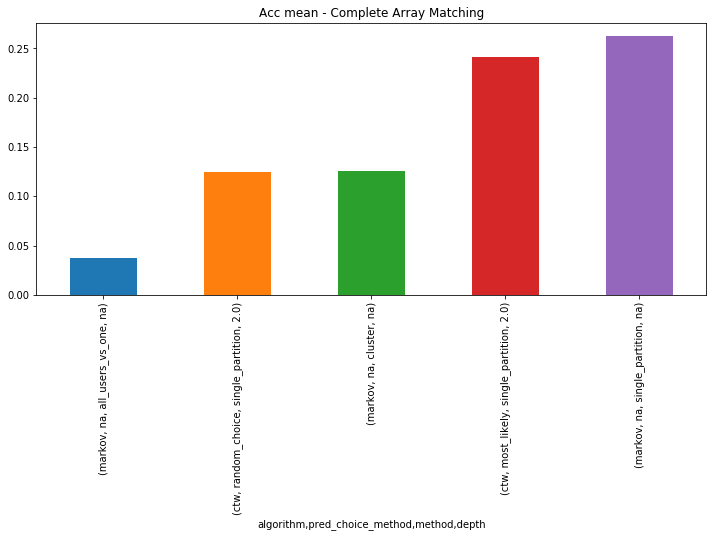

In [24]:
f, ax = plt.subplots(figsize=(12,5))
results_df.set_index(["algorithm", "pred_choice_method", "method", "depth"], drop=False).groupby(["algorithm", "pred_choice_method", "method", "depth"])["acc"].mean().sort_values().plot.bar(title="Acc mean - Complete Array Matching")